**Description:**
* Converting movie-review string data to a sparse feature vector
* Implementing a sentiment-analysis linear model using a sparse feature vector
* Implementing a sentiment-analysis DNN model using an embedding that projects data into two dimensions
* Visualizing the embedding to see what the model has learned about the relationships between words  

In [1]:
from __future__ import print_function
import collections
import io
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

40697856/40688441 [==============================] - 0s 0us/step


In [2]:
def _parse_function(record):
  features = {
    "terms": tf.VarLenFeature(dtype=tf.string),
    "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32)
  }
  parsed_features = tf.parse_single_example(record, features)
  terms = parsed_features['terms'].values
  labels = parsed_features['labels']
  return  {'terms':terms}, labels

In [3]:
ds = tf.data.TFRecordDataset(train_path)
ds = ds.map(_parse_function)
ds

<MapDataset shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

In [4]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array(['but', 'it', 'does', 'have', 'some', 'good', 'action', 'and', 'a',
         'plot', 'that', 'is', 'somewhat', 'interesting', '.', 'nevsky',
         'acts', 'like', 'a', 'body', 'builder', 'and', 'he', 'isn', "'",
         't', 'all', 'that', 'attractive', ',', 'in', 'fact', ',', 'imo',
         ',', 'he', 'is', 'ugly', '.', '(', 'his', 'acting', 'skills',
         'lack', 'everything', '!', ')', 'sascha', 'is', 'played', 'very',
         'well', 'by', 'joanna', 'pacula', ',', 'but', 'she', 'needed',
         'more', 'lines', 'than', 'she', 'was', 'given', ',', 'her',
         'character', 'needed', 'to', 'be', 'developed', '.', 'there',
         'are', 'way', 'too', 'many', 'men', 'in', 'this', 'story', ',',
         'there', 'is', 'zero', 'romance', ',', 'too', 'much', 'action',
         ',', 'and', 'way', 'too', 'dumb', 'of', 'an', 'ending', '.', 'it',
         'is', 'very', 'violent', '.', 'i', 'did', 'however', 'love', 'the',
         'scenery', ',', 'this', 'mov

In [5]:
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
  ds = tf.data.TFRecordDataset(input_filenames)
  ds = ds.map(_parse_function)
  if shuffle:
    ds = ds.shuffle(10000)
  ds = ds.padded_batch(25, ds.output_shapes)
  ds = ds.repeat(num_epochs)
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

In [6]:
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

In [7]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
feature_columns = [ terms_feature_column ]
classifier = tf.estimator.LinearClassifier(
  feature_columns=feature_columns,
  optimizer=my_optimizer,
)
classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")
evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)
print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 11.306146
accuracy_baseline 0.5
global_step 1000
recall 0.86664
auc 0.87175256
prediction/mean 0.5229406
precision 0.7470004
label/mean 0.5
average_loss 0.45224583
auc_precision_recall 0.86159253
accuracy 0.78656
---
Test set metrics:
loss 11.310845
accuracy_baseline 0.5
global_step 1000
recall 0.86304
auc 0.8704701
prediction/mean 0.52099425
precision 0.74698794
label/mean 0.5
average_loss 0.45243382
auc_precision_recall 0.8592919
accuracy 0.78536
---


In [8]:
classifier = tf.estimator.DNNClassifier(                                      
  feature_columns=[tf.feature_column.indicator_column(terms_feature_column)], 
  hidden_units=[20,20],                                                       
  optimizer=my_optimizer,                                                     
)                                                                             
try:
  classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)
  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1)
  print("Training set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")
  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1)
  print("Test set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")
except ValueError as err:
  print(err)

Training set metrics:
loss 19.487776
accuracy_baseline 0.68
global_step 1000
recall 0.875
auc 0.7205882
prediction/mean 0.5773572
precision 0.46666667
label/mean 0.32
average_loss 0.77951103
auc_precision_recall 0.43342984
accuracy 0.64
---
Test set metrics:
loss 14.489149
accuracy_baseline 0.52
global_step 1000
recall 0.6923077
auc 0.801282
prediction/mean 0.58946174
precision 0.6
label/mean 0.52
average_loss 0.57956594
auc_precision_recall 0.8173497
accuracy 0.6
---


In [9]:
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20,20],
  optimizer=my_optimizer
)
classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")
evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)
print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 11.399681
accuracy_baseline 0.5
global_step 1000
recall 0.76512
auc 0.8687329
prediction/mean 0.46989223
precision 0.7951447
label/mean 0.5
average_loss 0.45598722
auc_precision_recall 0.85751164
accuracy 0.784
---
Test set metrics:
loss 11.413533
accuracy_baseline 0.5
global_step 1000
recall 0.76264
auc 0.8682057
prediction/mean 0.4696014
precision 0.79349095
label/mean 0.5
average_loss 0.45654133
auc_precision_recall 0.8558814
accuracy 0.78208
---


In [10]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

In [11]:
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(50, 2)

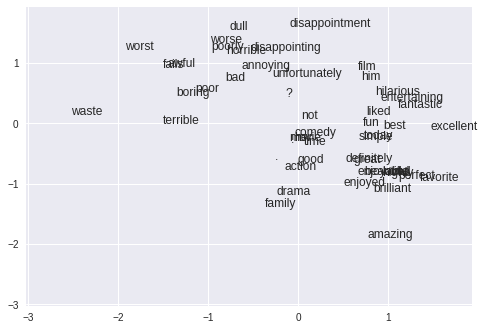

In [12]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')
for term_index in range(len(informative_terms)):
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

In [13]:
terms_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

262144/253538 [===============================] - 0s 0us/step


In [14]:
informative_terms = None
with io.open(terms_path, 'r', encoding='utf8') as f:
  informative_terms = list(set(f.read().split()))
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", 
                                                                                 vocabulary_list=informative_terms)
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)
classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")
evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)
print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 10.730894
accuracy_baseline 0.5
global_step 1000
recall 0.8436
auc 0.8876317
prediction/mean 0.53666854
precision 0.78965104
label/mean 0.5
average_loss 0.4292358
auc_precision_recall 0.8862256
accuracy 0.80944
---
Test set metrics:
loss 11.313155
accuracy_baseline 0.5
global_step 1000
recall 0.82072
auc 0.8735563
prediction/mean 0.53553027
precision 0.775376
label/mean 0.5
average_loss 0.4525262
auc_precision_recall 0.8723294
accuracy 0.79148
---
